In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

path_to_project = os.path.abspath(os.path.join(os.getcwd(), '../'))    
sys.path.insert(1, os.path.join(path_to_project))

## 2.1 Warm-up Exercise: Hypothesis Testing & Confounding [6 pts]

Task 2.1.1 [1 pts]. Implement the Log-Rank test from scratch in Python. Using the UNOS dataset, apply
your implemented test to check whether the survival outcomes of patients on ventricular assist device (VAD)
support differ from those of patients without VAD support.

In [38]:
import pandas as pd
from src.directory import dataset_paths
from src.metrics import log_rank_test

In [39]:
UNOS_data = pd.read_csv(dataset_paths['unos'])
event_col = "Censor (Censor = 1)"
time_col = "Survival Time"

In [41]:
log_rank_results = log_rank_test(UNOS_data, 
                                event_col="Censor (Censor = 1)", 
                                time_col="Survival Time",
                                group_col="vad_while_listed")
Z, p_value = log_rank_results
print(f'Log rank results: Z={Z}, p={p_value}')

Log rank results: Z=-8.955531156690666, p=0.005532614903659416


Task 2.1.2 [1 pts]. Propose a method to determine if there are confounders in the UNOS dataset for the ef-
fect of VAD support on survival outcomes. List all detected confounders.

In [5]:
from src.data_dict import feature_config
from src.utils import test_unconfoundedness_by_feature

In [47]:
vad_col = "vad_while_listed"
feature_cols = list(set(feature_config['unos']) - set([vad_col]))

In [7]:
# test unconfoundedness/conditional ignorability
confounders = test_unconfoundedness_by_feature(UNOS_data, 
                                               outcome_col=time_col,
                                               conditional_col=vad_col,
                                               feature_cols=feature_cols)
confounders

,corr,p_value,confounder
feature,,,
diab,0.036893,0.005821,True
iabp_tcr,-0.144937,0.0,True
wgt_kg_tcr,0.243293,0.0,True
most_rcnt_creat,0.03106,0.020262,True
tah,0.031514,0.018502,True
ecmo_tcr,0.1949,0.0,True
init_age,0.132576,0.0,True
hgt_cm_tcr,0.161952,0.0,True
abo_A,0.048125,0.000321,True


Task 2.1.3 [2 pts]. For the comparison of survival curves to have a causal interpretation, we need to adjust
for confounding variables that may cause the patient groups being compared to have different clinical features. Propose a propensity-weighted version of the Kaplan-Meier estimator you implemented in Project 1 that ad-
justs for confounding. Plot the propensity-weighted Kaplan-Meier curves in patients with and without VAD.
Compare this plot with the survival curves of both groups using the standard Kaplan-Meier estimators.

In [42]:
from copy import deepcopy
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
from src.estimators import kaplan_meier
from src.utils import get_propensity_scores


In [48]:
# get propensity scores
propensity_col = 'propensity_vad'
propensity_score = get_propensity_scores(UNOS_data, T_col=vad_col, X_cols=feature_cols)
propensity_df = deepcopy(UNOS_data)
propensity_df[propensity_col] = propensity_score

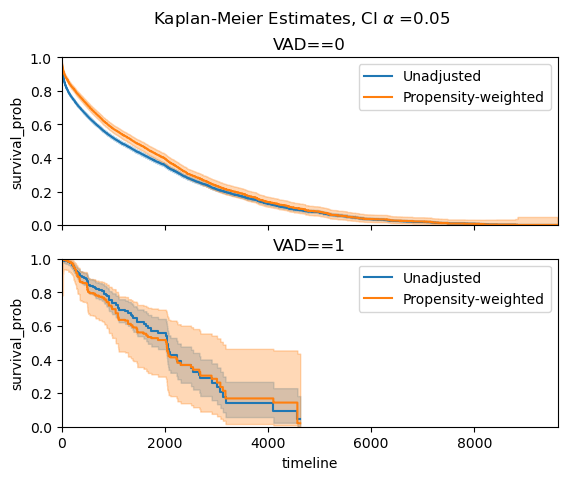

In [49]:
# set CI alpha
alpha = 0.05

# create figure
nrows = 2
fig, axs = plt.subplots(nrows=nrows, sharex=True)
axs = axs.ravel()
colors = sns.color_palette()

for i, group in enumerate([0,1]):
    ax = axs[i]

    # get group data
    group_data = propensity_df.query(f'{vad_col}=={group}')

    # plot lifelines KM
    kmf = KaplanMeierFitter(alpha=alpha)
    kmf.fit(group_data[time_col], event_observed=group_data[event_col])
    kmf.plot_survival_function(label=f'Unadjusted', ax=ax, c=colors[0])

    # get propensity-weighted KM estimate from scratch
    km_df = kaplan_meier(group_data, time_col, event_col, 
                         propensity_col=propensity_col, 
                         alpha=alpha)
    sns.lineplot(data=km_df, x='time', y='survival_prob',
                 drawstyle='steps-pre', ax=ax, label='Propensity-weighted', legend=True, c=colors[1])
    ax.fill_between(km_df['time'], km_df['ci_lower'], km_df['ci_upper'], alpha=0.3, color=colors[1])

    ax.set_title(f'VAD=={group}')
    ax.set_ylim([0, 1])
    ax.set_xlim([0, UNOS_data[time_col].max()])

plt.suptitle(fr'Kaplan-Meier Estimates, CI $\alpha$ ={alpha}')
plt.show()

Task 2.1.4 [2 pts]. Propose a propensity-weighted version of the Long-Rank test. Apply this test to check
whether the survival outcomes of patients on VAD support differ from those of patients without VAD. Com-
pare the result of this test with the unadjusted test you implemented in Task 2.1.1. Comment on the results.

In [51]:
log_rank_results = log_rank_test(propensity_df,
                                event_col="Censor (Censor = 1)", 
                                time_col="Survival Time",
                                group_col="vad_while_listed",
                                propensity_col=propensity_col)
Z, p_value = log_rank_results

print(f'Log rank results: Z={Z}, p={p_value}')

Log rank results: Z=-1.1346923772103832, p=0.5735533100601049


## 2.2 ML-based Estimation of Average Treatment Effects [6 pts]

Estimate the average effect of aspirin and heparin on 14-day mortality using the following estimators. Com-
pare your estimates with those of the original trial and provide commentary on the results

Task 2.2.1 [1 pts]. A standard difference-in-means estimator.<br />
Task 2.2.2 [1 pts]. An inverse propensity weighting (IPW) estimator using a Gradient Boosting model for
the propensity scores.<br />
Task 2.2.3 [2 pts]. A covariate adjustment estimator using a Gradient Boosting model with T-learner, S-
learner, and X-learner architectures.<br />
Task 2.2.4 [2 pts]. An augmented IPW (doubly-robust) estimator that combines the propensity model from
Task 2.2.2 and an outcomes model based on the S-learner in Task 2.2.3.

In [12]:
%reload_ext autoreload
%autoreload 2

import sys
import os

path_to_project = os.path.abspath(os.path.join(os.getcwd(), '../'))    
sys.path.insert(1, os.path.join(path_to_project))

In [25]:
from itertools import product
import pandas as pd
from src.directory import dataset_paths
from src.data_dict import feature_config
from src.utils import preprocess_ist, check_estimator_normality
from src.estimators import unadjusted_DM_estimator, ipw_estimator, t_learner, s_learner, x_learner, aipw_estimator, propensity_estimator

Seed set to 40
Seed set to 40
Seed set to 40


In [26]:
# outcomes 
mortality14_col = 'ID14'

# treatments
asp_col = 'DASP14'
low_dose_hep_col = 'DLH14'
med_dose_hep_cols = ['DMH14', 'DHH14']
heparin_cols = [low_dose_hep_col, *med_dose_hep_cols]
combined_hep_col = 'DH14'

# features
ist_feature_cols = feature_config['ist']

# columns to read in
select_ist_cols = [mortality14_col, asp_col, *heparin_cols, *ist_feature_cols]

# columns not to transform
untransformed_cols = [x for x in select_ist_cols if x in [mortality14_col, asp_col]]

In [27]:
# read in data
ist_corrected = pd.read_csv(dataset_paths['ist_corrected'], sep='\t', encoding='utf-16', usecols=select_ist_cols) # corrected
ist_original = pd.read_csv(dataset_paths['ist_original'], usecols=select_ist_cols) # observational

# preprocess
ist_corrected,covariates = preprocess_ist(ist_corrected, 
                                        feature_cols=ist_feature_cols,
                                        untransformed_cols=untransformed_cols,
                                        heparin_cols=heparin_cols,
                                        combined_hep_col=combined_hep_col)
ist_corrected.name = 'ist_corrected'

ist_original, _ = preprocess_ist(ist_original, 
                                feature_cols=ist_feature_cols,
                                untransformed_cols=untransformed_cols,
                                heparin_cols=heparin_cols,
                                combined_hep_col=combined_hep_col)
ist_original.name = 'ist_original'

/tmp/ipykernel_877595/3540400694.py:2: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  ist_corrected = pd.read_csv(dataset_paths['ist_corrected'], sep='\t', encoding='utf-16', usecols=select_ist_cols) # corrected
/home/hentipapai/PycharmProjects/cph-200b/src/utils.py:141: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({'Y':1, 'y':1, 'N':0, 'n':0, 'C':float('nan'), 'U': float('nan')})
/home/hentipapai/PycharmProjects/cph-200b/src/utils.py:141: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no

In [28]:
# set up results dataframe
estimators = [unadjusted_DM_estimator, ipw_estimator, t_learner, s_learner, x_learner, aipw_estimator]
ist_datasets = [ist_original, ist_corrected]

estimator_names = [x.__name__ for x in estimators]
dataset_names = [x.name for x in ist_datasets]
treatment_cols = [asp_col, combined_hep_col]
variance_cols = [f'var_{x}' for x in treatment_cols]

index = pd.MultiIndex.from_product([dataset_names, estimator_names], names=['dataset', 'estimator'])
tau_results = pd.DataFrame(index=index, columns=treatment_cols+variance_cols)

In [29]:
for data, tau_estimator, treatment in product(ist_datasets, estimators, treatment_cols):
    estimator_name = tau_estimator.__name__
    dataset_name = data.name
    var_estimator = f'var_{treatment}'
    if dataset_name == 'ist_original' and estimator_name != 'unadjusted_DM_estimator':
        continue
    treatment_observed = ~data[treatment].isna()
    tau, var_tau = tau_estimator(data[treatment_observed], treatment_var=treatment, outcome_var=mortality14_col, covariates=covariates)
    tau_results.loc[(dataset_name, estimator_name), [treatment, var_estimator]] = tau, var_tau
    print(f"{dataset_name} {estimator_name}, avg. effect for {treatment}: {tau}")

tau_results.dropna(inplace=True, how='all')

ist_original unadjusted_DM_estimator, avg. effect for DASP14: -0.03498893363044499
ist_original unadjusted_DM_estimator, avg. effect for DH14: -0.0033441506096889423
ist_corrected unadjusted_DM_estimator, avg. effect for DASP14: -0.012013646271336456
ist_corrected unadjusted_DM_estimator, avg. effect for DH14: -0.005129427847479398
ist_corrected ipw_estimator, avg. effect for DASP14: -0.00939731499574887
ist_corrected ipw_estimator, avg. effect for DH14: -0.0038172778981488496
ist_corrected t_learner, avg. effect for DASP14: -0.0009278828805608536
ist_corrected t_learner, avg. effect for DH14: -0.0030872137895549268
ist_corrected s_learner, avg. effect for DASP14: -0.0016495695654415183
ist_corrected s_learner, avg. effect for DH14: -0.00041162850527399
ist_corrected x_learner, avg. effect for DASP14: 0.001132107240813127
ist_corrected x_learner, avg. effect for DH14: 0.00488372211868177
ist_corrected aipw_estimator, avg. effect for DASP14: -0.01015381819344442
ist_corrected aipw_estim

In [30]:
# compare tau
# get difference 
diff_in_tau = tau_results.query('dataset=="ist_corrected"')[treatment_cols] - \
    tau_results.query('dataset=="ist_original"')[treatment_cols].values

# get squared error
mse_tau = diff_in_tau ** 2
mse_tau.sort_values(treatment_cols[0], inplace=True)

print('Squared error between true tau and estimates:') 
mse_tau

Squared error between true tau and estimates:


DASP14      DH14
dataset       estimator                                  
ist_corrected unadjusted_DM_estimator  0.000528  0.000003
              aipw_estimator           0.000617  0.000002
              ipw_estimator            0.000655       0.0
              s_learner                0.001112  0.000009
              t_learner                 0.00116       0.0
              x_learner                0.001305  0.000068

In [19]:
# # check non-parametric efficiency/asymptotic normality
# for treatment in treatment_cols:
#     var_estimator = f'var_{treatment}'
#     treatment_observed = ~ist_corrected[treatment].isna()
#     data = ist_corrected[treatment_observed]

#     X = data[covariates]
#     T = data[treatment]
#     pi = propensity_estimator(X,T)

#     tau_true = tau_results.loc[('ist_original', 'unadjusted_DM_estimator'), treatment] 

#     for tau_estimator in estimators:
#         estimator_name = tau_estimator.__name__
#         if estimator_name == 'unadjusted_DM_estimator':
#             continue

#         tau_est = tau_results.loc[('ist_corrected', estimator_name), treatment] 
        
#         test_value = X.shape[0] ** 0.5 * (tau_est - tau_true)

#         term1 = tau_results.loc[(dataset_name, estimator_name), var_estimator]
#         term2 =  X.var(axis=1) / (pi * (1 - pi)) # TODO: correctly calculate var of X
#         v_agg =  term1 + term2.mean()

#         efficiency = check_estimator_normality(value=test_value, variance=v_agg)
#         tau_results.loc[('ist_corrected', estimator_name), efficiency.keys()] = efficiency.values()
#         print(f"{treatment} {estimator_name}, asymptotically normal: {efficiency['significant']}")
#     print('\n')

## 2.3 Counterfactual Inference and Domain Adaptation [8 pts]

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

path_to_project = os.path.abspath(os.path.join(os.getcwd(), '../'))    
sys.path.insert(1, os.path.join(path_to_project))

Task 2.3.1 [3 pts]. Implement the TARNet and CFRMMD models proposed in [3] in PyTorch. Evaluate
the performance of all models using the semi-synthetic benchmark dataset included in the Project 2 notebook.

Task 2.3.2 [1 pts]. Visualize the treated and control features before and after applying the balancing rep-
resentation Φ(.) using t-SNE. Comment on the results.

In [2]:
import numpy as np
import pandas as pd
from src.lightning_pipelines import CFR_training_pipeline
from src.directory import dataset_paths
from src.data_dict import feature_config

Seed set to 40


In [3]:
# read in data
dataset_name = 'ihdp'
data = pd.read_csv(dataset_paths[dataset_name], index_col=0)

# set training variables
treatment_col = 'T'
outcome_col = 'Y'
input_features = feature_config[dataset_name]
input_dim = len(input_features)
outcome_type = 'binary' if data[outcome_col].nunique() == 2 else 'continuous'
wandb_kwargs = dict(project_name='CPH_200B', 
                    wandb_entity='furtheradu', 
                    dir_path='notebooks/..',
                    offline=True)

In [4]:
# CFR MMD (alpha > 0)
model_name = 'CFR_MMD'
alpha = np.logspace(0,1,9)[2]  # per (Shalit, 2017) figure 2

pipeline_out = CFR_training_pipeline(
    model_name=model_name,
    treatment_col=treatment_col,
    outcome_col=outcome_col,
    input_features=input_features,
    dataset_name=dataset_name,
    alpha=alpha,
    outcome_type=outcome_type,
    wandb_kwargs=wandb_kwargs
    )

trainer, model, datamodule = [pipeline_out[x] for x in ['trainer', 'model', 'datamodule']]

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training model


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id wuv9h2c2.


Processing ihdp Dataset: 747it [00:00, 23136.33it/s]
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hentipapai/PycharmProjects/cph-200b/logs/CFR_MMD/version_10 exists and is not empty.

  | Name    | Type                          | Params | Mode 
------------------------------------------------------------------
0 | loss_fn | MSELoss                       | 0      | train
1 | model   | CounterfactualRegressionTorch | 147 K  | train
------------------------------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.590     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [5]:
print("Testing model")
test_pred = trainer.test(model, datamodule)
print(f'Test set\nMSE: {test_pred[0]["test_MSELoss"]}')

Testing model


Processing ihdp Dataset: 747it [00:00, 21653.44it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_MSELoss          1.7754243410393338
        test_tau             4.434502938763791
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test set
MSE: 1.7754243410393338


In [6]:
# TARNet (alpha == 0), without balance regularization
model_name = 'TARNet'
alpha = 0

pipeline_out = CFR_training_pipeline(
    model_name=model_name,
    treatment_col=treatment_col,
    outcome_col=outcome_col,
    input_features=input_features,
    dataset_name=dataset_name,
    alpha=alpha,
    outcome_type=outcome_type,
    wandb_kwargs=wandb_kwargs
    )

trainer, model, datamodule = [pipeline_out[x] for x in ['trainer', 'model', 'datamodule']]

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Training model


Processing ihdp Dataset: 747it [00:00, 23979.74it/s]
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hentipapai/PycharmProjects/cph-200b/logs/TARNet/version_10 exists and is not empty.

  | Name    | Type                          | Params | Mode 
------------------------------------------------------------------
0 | loss_fn | MSELoss                       | 0      | train
1 | model   | CounterfactualRegressionTorch | 147 K  | train
------------------------------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.590     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [7]:
print("Testing model")
test_pred = trainer.test(model, datamodule)
# test_loss = trainer.predict(model, datamodule)
print(f'Test set\nMSE: {test_pred[0]["test_MSELoss"]}')

Testing model


Processing ihdp Dataset: 747it [00:00, 15083.94it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_MSELoss           1.603144642744273
        test_tau            4.1734228038910155
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Test set
MSE: 1.603144642744273


Task 2.3.3 [1 pts]. Show the impact of the scaling parameter α (Eq. (3) in [3]) on the loss function on the
test set for the Maximum Mean Discrepancy (MMD) regularizer.

In [ ]:
%reload_ext autoreload
%autoreload 2

import sys
import os

path_to_project = os.path.abspath(os.path.join(os.getcwd(), '../'))    
sys.path.insert(1, os.path.join(path_to_project))

In [ ]:
import numpy as np
import pandas as pd
from src.lightning_pipelines import CFR_training_pipeline
from src.directory import dataset_paths
from src.data_dict import feature_config

In [ ]:
# read in data
dataset_name = 'ihdp'
data = pd.read_csv(dataset_paths[dataset_name], index_col=0)

# set training variables
treatment_col = 'T'
outcome_col = 'Y'
input_features = feature_config[dataset_name]
input_dim = len(input_features)
outcome_type = 'binary' if data[outcome_col].nunique() == 2 else 'continuous'
wandb_kwargs = dict(project_name='CPH_200B', 
                    wandb_entity='furtheradu', 
                    dir_path='notebooks/..',
                    offline=True)

In [ ]:
# set up results dataframe
model_name = 'CFR_MMD'
alphas = np.logspace(0,1,9)
metric_name = 'test_MSEloss'

alpha_results = pd.DataFrame(index=alphas, columns=[])
alpha_results.index.name = 'alpha'

In [ ]:
for alpha in alphas:
    print(f'Training model {model_name} on {dataset_name} to get test loss with alpha == {alpha}')
    pipeline_out = CFR_training_pipeline(
        model_name=model_name,
        treatment_col=treatment_col,
        outcome_col=outcome_col,
        input_features=input_features,
        dataset_name=dataset_name,
        alpha=alpha,
        outcome_type=outcome_type,
        wandb_kwargs=wandb_kwargs,
        raw_data=data.dropna(subset=[treatment_col])
    )

    trainer, model, datamodule = [pipeline_out[x] for x in ['trainer', 'model', 'datamodule']]
    
    print("Testing model")
    test_pred = trainer.test(model, datamodule)
    
    # log results to df
    alpha_results.loc[alpha, test_pred[0].keys()] = test_pred[0].values()
    print(f'Finished training.\n\n')

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Training model CFR_MMD on ihdp to get test loss with alpha == 1.0
Training model


Processing ihdp Dataset: 747it [00:00, 22640.29it/s]
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hentipapai/PycharmProjects/cph-200b/logs/CFR_MMD/version_10 exists and is not empty.

  | Name    | Type                          | Params | Mode 
------------------------------------------------------------------
0 | loss_fn | MSELoss                       | 0      | train
1 | model   | CounterfactualRegressionTorch | 147 K  | train
------------------------------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.590     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing ihdp Dataset: 747it [00:00, 22908.13it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_MSELoss          1.5260569254941752
        test_tau             4.75644258906631
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Finished training.


Training model CFR_MMD on ihdp to get test loss with alpha == 1.333521432163324
Training model


Processing ihdp Dataset: 747it [00:00, 23689.11it/s]
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hentipapai/PycharmProjects/cph-200b/logs/CFR_MMD/version_10 exists and is not empty.

  | Name    | Type                          | Params | Mode 
------------------------------------------------------------------
0 | loss_fn | MSELoss                       | 0      | train
1 | model   | CounterfactualRegressionTorch | 147 K  | train
------------------------------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.590     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing ihdp Dataset: 747it [00:00, 21594.49it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_MSELoss          1.7137497895805216
        test_tau             4.798574594563939
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Finished training.


Training model CFR_MMD on ihdp to get test loss with alpha == 1.7782794100389228
Training model


Processing ihdp Dataset: 747it [00:00, 15908.97it/s]
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hentipapai/PycharmProjects/cph-200b/logs/CFR_MMD/version_10 exists and is not empty.

  | Name    | Type                          | Params | Mode 
------------------------------------------------------------------
0 | loss_fn | MSELoss                       | 0      | train
1 | model   | CounterfactualRegressionTorch | 147 K  | train
------------------------------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.590     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing ihdp Dataset: 747it [00:00, 23318.86it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_MSELoss          1.8599673493006452
        test_tau             4.608462046552704
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Finished training.


Training model CFR_MMD on ihdp to get test loss with alpha == 2.371373705661655
Training model


Processing ihdp Dataset: 747it [00:00, 18806.28it/s]
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hentipapai/PycharmProjects/cph-200b/logs/CFR_MMD/version_10 exists and is not empty.

  | Name    | Type                          | Params | Mode 
------------------------------------------------------------------
0 | loss_fn | MSELoss                       | 0      | train
1 | model   | CounterfactualRegressionTorch | 147 K  | train
------------------------------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.590     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing ihdp Dataset: 747it [00:00, 22963.54it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_MSELoss          1.6228644634093008
        test_tau            4.6530528455941935
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Finished training.


Training model CFR_MMD on ihdp to get test loss with alpha == 3.1622776601683795
Training model


Processing ihdp Dataset: 747it [00:00, 20217.36it/s]
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hentipapai/PycharmProjects/cph-200b/logs/CFR_MMD/version_10 exists and is not empty.

  | Name    | Type                          | Params | Mode 
------------------------------------------------------------------
0 | loss_fn | MSELoss                       | 0      | train
1 | model   | CounterfactualRegressionTorch | 147 K  | train
------------------------------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.590     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing ihdp Dataset: 747it [00:00, 15975.49it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_MSELoss          1.7755227046206952
        test_tau             4.716183111406352
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Finished training.


Training model CFR_MMD on ihdp to get test loss with alpha == 4.216965034285822
Training model


Processing ihdp Dataset: 747it [00:00, 23379.41it/s]
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hentipapai/PycharmProjects/cph-200b/logs/CFR_MMD/version_10 exists and is not empty.

  | Name    | Type                          | Params | Mode 
------------------------------------------------------------------
0 | loss_fn | MSELoss                       | 0      | train
1 | model   | CounterfactualRegressionTorch | 147 K  | train
------------------------------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.590     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing ihdp Dataset: 747it [00:00, 20715.42it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_MSELoss          1.7565628208284279
        test_tau             4.773802890929985
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Finished training.


Training model CFR_MMD on ihdp to get test loss with alpha == 5.623413251903491
Training model


Processing ihdp Dataset: 747it [00:00, 22904.78it/s]
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hentipapai/PycharmProjects/cph-200b/logs/CFR_MMD/version_10 exists and is not empty.

  | Name    | Type                          | Params | Mode 
------------------------------------------------------------------
0 | loss_fn | MSELoss                       | 0      | train
1 | model   | CounterfactualRegressionTorch | 147 K  | train
------------------------------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.590     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing ihdp Dataset: 747it [00:00, 18792.41it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_MSELoss          1.8400685672788601
        test_tau             4.548419119241753
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Finished training.


Training model CFR_MMD on ihdp to get test loss with alpha == 7.498942093324558
Training model


Processing ihdp Dataset: 747it [00:00, 23574.14it/s]
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hentipapai/PycharmProjects/cph-200b/logs/CFR_MMD/version_10 exists and is not empty.

  | Name    | Type                          | Params | Mode 
------------------------------------------------------------------
0 | loss_fn | MSELoss                       | 0      | train
1 | model   | CounterfactualRegressionTorch | 147 K  | train
------------------------------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.590     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing ihdp Dataset: 747it [00:00, 18032.49it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_MSELoss          1.8280222397065296
        test_tau             4.571989292510088
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Finished training.


Training model CFR_MMD on ihdp to get test loss with alpha == 10.0
Training model


Processing ihdp Dataset: 747it [00:00, 11259.73it/s]
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hentipapai/PycharmProjects/cph-200b/logs/CFR_MMD/version_10 exists and is not empty.

  | Name    | Type                          | Params | Mode 
------------------------------------------------------------------
0 | loss_fn | MSELoss                       | 0      | train
1 | model   | CounterfactualRegressionTorch | 147 K  | train
------------------------------------------------------------------
147 K     Trainable params
0         Non-trainable params
147 K     Total params
0.590     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing ihdp Dataset: 747it [00:00, 23417.51it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_MSELoss           1.989280279841746
        test_tau             4.069600059186065
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Finished training.




In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

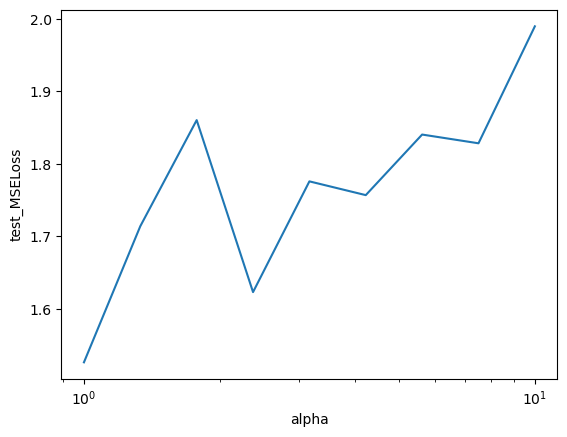

In [ ]:
alpha_results.index.name = 'alpha'
sns.lineplot(data=alpha_results, x='alpha', y='test_MSELoss')
plt.xscale('log')

In [ ]:
# import wandb
# from operator import mul
# from functools import reduce

In [ ]:
# # define sweep function
# def train_model():
#     # init wandb
#     wandb.init(group=model_name, **wandb_kwargs)

#     pipeline_out = CFR_training_pipeline(
#         model_name=model_name,
#         treatment_col=treatment_col,
#         outcome_col=outcome_col,
#         input_features=input_features,
#         dataset_name=dataset_name,
#         alpha=wandb.config['alpha'],
#         outcome_type=outcome_type,
#         wandb_kwargs=wandb_kwargs
#     )

#     trainer, model, datamodule = [pipeline_out[x] for x in ['trainer', 'model', 'datamodule']]

#     print("Best model checkpoint path: ", trainer.checkpoint_callback.best_model_path)

In [ ]:
# model_name = 'CFR_MMD'
# print(f'Running sweep for model "{model_name}"')
    
# # get search parameters
# alphas = np.logspace(0,1,9)
# parameters = {'alpha': {'values': alphas.tolist()}}

# # set num
# count = reduce(mul, [len(v['values']) for v in parameters.values()], 1)

# # define sweep config
# sweep_config = {
#     'method': 'grid',
#     'name': 'sweep_MMD',
#     'metric': {
#         'goal': 'minimize',
#         'name': 'val_loss'
#     },
#     'parameters': parameters
# }

# # init sweep
# sweep_id = wandb.sweep(sweep_config, 
#                        project=wandb_kwargs['project_name'],
#                        entity=wandb_kwargs['wandb_entity'])

# wandb.agent(sweep_id=sweep_id, 
#             function=train_model, 
#             count=count)

Task 2.3.4 [3 pts]. Use the TARNet and CFRMMD models to estimate average treatment effects using
the IST data in Task 2.2. Assess the alignment of your estimates with the trial results and compare them
to the estimators in Tasks 2.2.3 and 2.2.4.

In [ ]:
%reload_ext autoreload
%autoreload 2

import sys
import os

path_to_project = os.path.abspath(os.path.join(os.getcwd(), '../'))    
sys.path.insert(1, os.path.join(path_to_project))

In [ ]:
import numpy as np
import pandas as pd
from src.lightning_pipelines import CFR_training_pipeline
from src.directory import dataset_paths
from src.data_dict import feature_config
from src.utils import preprocess_ist

In [ ]:
## IST variables
# outcomes 
mortality14_col = 'ID14'

# treatments
asp_col = 'DASP14'
low_dose_hep_col = 'DLH14'
med_dose_hep_cols = ['DMH14', 'DHH14']
heparin_cols = [low_dose_hep_col, *med_dose_hep_cols]
combined_hep_col = 'DH14'

# features
ist_feature_cols = feature_config['ist']

# columns to read in
select_ist_cols = [mortality14_col, asp_col, *heparin_cols, *ist_feature_cols]

# columns not to transform
untransformed_cols = [x for x in select_ist_cols if x in [mortality14_col, asp_col]]

In [ ]:
# read in data
dataset_name = 'ist_corrected'
data = pd.read_csv(dataset_paths[dataset_name], sep='\t', encoding='utf-16', usecols=select_ist_cols)

# preprocess
data, covariates = preprocess_ist(data, 
                                feature_cols=ist_feature_cols,
                                untransformed_cols=untransformed_cols,
                                heparin_cols=heparin_cols,
                                combined_hep_col=combined_hep_col)
data.name = dataset_name
treatment_cols = ['DASP14', 'DH14']
outcome_col = 'ID14'
input_features = covariates
input_dim = len(input_features)
outcome_type = 'binary' if data[outcome_col].nunique() == 2 else 'continuous'

wandb_kwargs = dict(project_name='CPH_200B', 
                    wandb_entity='furtheradu', 
                    dir_path='CPH-200B/',
                    offline=True)

/tmp/ipykernel_877595/3676856551.py:3: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_paths[dataset_name], sep='\t', encoding='utf-16', usecols=select_ist_cols)
/home/hentipapai/PycharmProjects/cph-200b/src/utils.py:141: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({'Y':1, 'y':1, 'N':0, 'n':0, 'C':float('nan'), 'U': float('nan')})


In [ ]:
# set up results dataframe
estimator_names = ['TARNet', 'CFR_MMD']
alphas = [0, 1]
dataset_names = [data.name]
treatment_cols = [asp_col, combined_hep_col]

index = pd.MultiIndex.from_product([dataset_names, estimator_names], names=['dataset', 'estimator'])
DL_tau_results = pd.DataFrame(index=index, columns=treatment_cols)

In [ ]:
for model_name, alpha in dict(zip(estimator_names, alphas)).items():
    for treatment_col in treatment_cols:
        print(f'Training model {model_name} on {dataset_name} to predict CATE of {treatment_col} on {outcome_col}')
        pipeline_out = CFR_training_pipeline(
            model_name=model_name,
            treatment_col=treatment_col,
            outcome_col=outcome_col,
            input_features=input_features,
            dataset_name=dataset_name,
            alpha=alpha,
            outcome_type=outcome_type,
            wandb_kwargs=wandb_kwargs,
            raw_data=data.dropna(subset=[treatment_col])
        )

        trainer, model, datamodule = [pipeline_out[x] for x in ['trainer', 'model', 'datamodule']]
        
        print("Testing model")
        test_pred = trainer.test(model, datamodule)
        tau = test_pred[0]['test_tau']
        
        # log results to df
        DL_tau_results.loc[(dataset_name, model_name), treatment_col] = tau
        print(f'Finished training.\n\n')

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Training model TARNet on ist_corrected to predict CATE of DASP14 on ID14
Training model


Processing ist_corrected Dataset: 19399it [00:03, 5870.84it/s]
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hentipapai/PycharmProjects/cph-200b/logs/TARNet/version_10 exists and is not empty.

  | Name    | Type                          | Params | Mode 
------------------------------------------------------------------
0 | loss_fn | BCEWithLogitsLoss             | 0      | train
1 | model   | CounterfactualRegressionTorch | 150 K  | train
------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.603     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing ist_corrected Dataset: 19399it [00:03, 6119.76it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 test_BCEWithLogitsLoss     0.2823049918666246
        test_tau           -0.21664155119923123
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Finished training.


Training model TARNet on ist_corrected to predict CATE of DH14 on ID14
Training model


Processing ist_corrected Dataset: 19435it [00:03, 6437.83it/s]
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hentipapai/PycharmProjects/cph-200b/logs/TARNet/version_10 exists and is not empty.

  | Name    | Type                          | Params | Mode 
------------------------------------------------------------------
0 | loss_fn | BCEWithLogitsLoss             | 0      | train
1 | model   | CounterfactualRegressionTorch | 150 K  | train
------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.603     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing ist_corrected Dataset: 19435it [00:03, 6030.20it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 test_BCEWithLogitsLoss     0.2762618171505482
        test_tau           -0.18948500773874022
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Finished training.


Training model CFR_MMD on ist_corrected to predict CATE of DASP14 on ID14
Training model


Processing ist_corrected Dataset: 19399it [00:03, 5934.60it/s]
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hentipapai/PycharmProjects/cph-200b/logs/CFR_MMD/version_10 exists and is not empty.

  | Name    | Type                          | Params | Mode 
------------------------------------------------------------------
0 | loss_fn | BCEWithLogitsLoss             | 0      | train
1 | model   | CounterfactualRegressionTorch | 150 K  | train
------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.603     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing ist_corrected Dataset: 19399it [00:04, 4319.91it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 test_BCEWithLogitsLoss     0.27476650425476296
        test_tau            -0.2132048966802964
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Finished training.


Training model CFR_MMD on ist_corrected to predict CATE of DH14 on ID14


HPU available: False, using: 0 HPUs
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Training model


Processing ist_corrected Dataset: 19435it [00:02, 7785.07it/s]
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/hentipapai/PycharmProjects/cph-200b/logs/CFR_MMD/version_10 exists and is not empty.

  | Name    | Type                          | Params | Mode 
------------------------------------------------------------------
0 | loss_fn | BCEWithLogitsLoss             | 0      | train
1 | model   | CounterfactualRegressionTorch | 150 K  | train
------------------------------------------------------------------
150 K     Trainable params
0         Non-trainable params
150 K     Total params
0.603     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing ist_corrected Dataset: 19435it [00:04, 4275.38it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
 test_BCEWithLogitsLoss     0.27320287287791584
        test_tau           -0.12334576173116618
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Finished training.




In [ ]:
# compare tau
# get difference 
DL_diff_in_tau = DL_tau_results.query('dataset=="ist_corrected"')[treatment_cols] - \
    tau_results.query('dataset=="ist_original"')[treatment_cols].values 

# get squared error
DL_mse_tau = DL_diff_in_tau ** 2
DL_mse_tau.sort_values(treatment_cols[0], inplace=True)

print('Squared error between true tau and estimates:') 
pd.concat([DL_mse_tau, mse_tau])

Squared error between true tau and estimates:


DASP14      DH14
dataset       estimator                                  
ist_corrected CFR_MMD                  0.031761    0.0144
              TARNet                   0.032998  0.034648
              unadjusted_DM_estimator  0.000528  0.000003
              aipw_estimator           0.000617  0.000002
              ipw_estimator            0.000655       0.0
              s_learner                0.001112  0.000009
              t_learner                 0.00116       0.0
              x_learner                0.001305  0.000068

## 2.4 NeurIPS Reviewer for a Day: Reviewing & Reproducing Recent Research on ML-Based Causal Inference [10 pts]

Task 2.4.2 [5 pts]. Implement the DragonNet and Targeted regularization methods proposed in this pa-
per in PyTorch and reproduce their performance results on the IHDP dataset (Table 1 in the paper).

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

path_to_project = os.path.abspath(os.path.join(os.getcwd(), '../'))    
sys.path.insert(1, os.path.join(path_to_project))

In [2]:
import numpy as np
import pandas as pd
from src.lightning_pipelines import DragonNet_training_pipeline
from src.directory import dataset_paths
from src.data_dict import feature_config

Seed set to 40


In [4]:
# read in data
dataset_name = 'ihdp'
data = pd.read_csv(dataset_paths[dataset_name], index_col=0)

# set training variables
treatment_col = 'T'
outcome_col = 'Y'
alpha = 1.0
beta = 1.0
input_features = feature_config[dataset_name]
input_dim = len(input_features)
wandb_kwargs = dict(project_name='CPH_200B', 
                    wandb_entity='furtheradu', 
                    dir_path='notebooks/..',
                    offline=True)

In [5]:
# set up results dataframe
target_regs = [True, False]
model_name = 'DragonNet'

dragon_tau_results = pd.DataFrame(index=target_regs, columns=[f'τ_{treatment_col}'])
dragon_tau_results.index.name = 'target_reg'

In [6]:
for target_reg in target_regs:
    print(f'Training model {model_name} on {dataset_name} with target_reg == {target_reg} to predict CATE of {treatment_col} on {outcome_col}')
    pipeline_out = DragonNet_training_pipeline(
        model_name=model_name,
        treatment_col=treatment_col,
        outcome_col=outcome_col,
        input_features=input_features,
        dataset_name=dataset_name,
        alpha=alpha,
        beta=beta,
        target_reg=target_reg,
        wandb_kwargs=wandb_kwargs,
    )

    trainer, model, datamodule = [pipeline_out[x] for x in ['trainer', 'model', 'datamodule']]
    
    print("Testing model")
    test_pred = trainer.test(model, datamodule)
    tau = test_pred[0]['test_tau']
    
    # log results to df
    dragon_tau_results.loc[target_reg, f'τ_{treatment_col}'] = tau
    print(f'Finished training.\n\n')

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training model DragonNet on ihdp with target_reg == True to predict CATE of T on Y
Training model


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id riqrzwkq.


Processing ihdp Dataset: 747it [00:00, 23693.05it/s]

  | Name         | Type           | Params | Mode 
--------------------------------------------------------
0 | model        | DragonNetTorch | 107 K  | train
  | other params | n/a            | 1      | n/a  
--------------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.429     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing ihdp Dataset: 747it [00:00, 11984.14it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hentipapai/miniconda3/envs/cph-200b/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_dragon_net_loss              1.6398006883763452
            test_loss                    2.985272780077585
test_targeted_regularization_loss        1.34547209170124
            test_tau                    4.8728600508811715
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Finished training.


Training model DragonNet on ihdp with target_reg == False to predict CATE of T on Y
Training model


Processing ihdp Dataset: 747it [00:00, 12483.35it/s]

  | Name  | Type           | Params | Mode 
-------------------------------------------------
0 | model | DragonNetTorch | 107 K  | train
-------------------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.429     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing ihdp Dataset: 747it [00:00, 15847.50it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_dragon_net_loss              1.7933195518802225
            test_loss                    1.793319582939148
test_targeted_regularization_loss               0.0
            test_tau                     4.934310406833807
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Finished training.




In [30]:
sample_ATE = data.query("T==1")['Y'].mean() - data.query("T==0")['Y'].mean()
absolute_error = abs(dragon_tau_results - sample_ATE)

print('Absolute error between estimate and sample ATE')
absolute_error

Absolute error between estimate and sample ATE


,τ_T
target_reg,
True,0.195582
False,0.257032
